## Data load

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoontaewoo","key":"e1533af8f36cca2e5b68d8edda7158fb"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c hubmap-organ-segmentation

100% 5.77G/5.78G [02:41<00:00, 47.9MB/s]
100% 5.78G/5.78G [02:41<00:00, 38.5MB/s]


In [ ]:
! kaggle datasets download -d minsukoh/hubmap-mask-use-img0

 52% 9.00M/17.3M [00:00<00:00, 12.9MB/s]
100% 17.3M/17.3M [00:00<00:00, 23.0MB/s]


In [ ]:
! unzip /content/hubmap-organ-segmentation.zip

Archive:  /content/hubmap-organ-segmentation.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_images/10078.tiff  
  inflating: train.csv               
  inflating: train_annotations/10044.json  
  inflating: train_annotations/10274.json  
  inflating: train_annotations/10392.json  
  inflating: train_annotations/10488.json  
  inflating: train_annotations/10610.json  
  inflating: train_annotations/10611.json  
  inflating: train_annotations/10651.json  
  inflating: train_annotations/10666.json  
  inflating: train_annotations/10703.json  
  inflating: train_annotations/10892.json  
  inflating: train_annotations/10912.json  
  inflating: train_annotations/10971.json  
  inflating: train_annotations/10992.json  
  inflating: train_annotations/11064.json  
  inflating: train_annotations/1123.json  
  inflating: train_annotations/11448.json  
  inflating: train_annotations/11497.json  
  inflating: train_annotations/1157.json  
  inflati

In [ ]:
import os
os.mkdir('/content/mask')
! unzip /content/hubmap-mask-use-img0.zip -d /content/mask

Archive:  /content/hubmap-mask-use-img0.zip
  inflating: /content/mask/10044.jpg  
  inflating: /content/mask/10274.jpg  
  inflating: /content/mask/10392.jpg  
  inflating: /content/mask/10488.jpg  
  inflating: /content/mask/10610.jpg  
  inflating: /content/mask/10611.jpg  
  inflating: /content/mask/10651.jpg  
  inflating: /content/mask/10666.jpg  
  inflating: /content/mask/10703.jpg  
  inflating: /content/mask/10892.jpg  
  inflating: /content/mask/10912.jpg  
  inflating: /content/mask/10971.jpg  
  inflating: /content/mask/10992.jpg  
  inflating: /content/mask/11064.jpg  
  inflating: /content/mask/1123.jpg  
  inflating: /content/mask/11448.jpg  
  inflating: /content/mask/11497.jpg  
  inflating: /content/mask/1157.jpg  
  inflating: /content/mask/11629.jpg  
  inflating: /content/mask/11645.jpg  
  inflating: /content/mask/11662.jpg  
  inflating: /content/mask/1168.jpg  
  inflating: /content/mask/1184.jpg  
  inflating: /content/mask/11890.jpg  
  inflating: /content/ma

# library, csv load

In [ ]:
import glob
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models, utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff 
import cv2
from tensorflow.keras.preprocessing import image
import os

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.shape, test.shape

((351, 10), (1, 7))

In [ ]:
img_paths = sorted(glob.glob('/content/train_images/*tiff'))
len(img_paths)

351

# functions

In [ ]:
# def crop_img_saver(path, directory, size):
#     w = h = size
#     im = Image.open(path)
    
#     im_resize = im.resize((3000, 3000))
   
#     im = np.array(im_resize)

#     tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     name, _ = os.path.splitext(os.path.basename(path))
#     for k, tile in enumerate(tiles):

#         if tile.shape[:2] != (h, w):  
#             tile_ = tile
#             tile = np.zeros_like(tiles[0])
#             tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_

#         path = os.path.join(directory, f"{name}_{k:03}.jpg")
#         Image.fromarray(tile).save(path)

# os.mkdir('/content/crop_img')
# os.mkdir('/content/crop_mask')
# os.mkdir('/content/crop_img/lung')
# os.mkdir('/content/crop_mask/lung')

# # crop image save

# img_dir = '/content/crop_img/lung'

# for path in lung_paths :
#   resize_tile_image(path, img_dir, 1000)

# # crop mask save

# mask_dir = '/content/crop_mask/lung'
# for path in lung_mask_paths :
#   resize_tile_image(path, mask_dir, 1000)

# crop_img_paths = sorted(glob.glob('/content/crop_img/lung/*jpg'))
# crop_mask_paths = sorted(glob.glob('/content/crop_mask/lung/*jpg'))
# print(len(crop_img_paths), len(crop_mask_paths))

In [ ]:
# 장기별 id 구분
ids = []
organs = train['organ'].unique()

for i,organ in enumerate(organs) :
    mask = train[train['organ'] == organ]
    ids.append(mask['id'])
    print(f'{organ} : {len(ids[i])}')

prostate : 93
spleen : 53
lung : 48
kidney : 99
largeintestine : 58


In [ ]:
def data_path(target, paths, mask = False) :
  paths = sorted(paths)
  data_paths = []

  ids = train[train['organ'] == target]['id']
  path_ids = []

  if mask :
    for id in ids :
      path = f'/content/mask/{id}.jpg'
      data_paths.append(path)
  else : 
    for id in ids :
      path = f'/content/train_images/{id}.tiff' 
      data_paths.append(path)

  return data_paths
mask_paths = sorted(glob.glob('/content/mask/*jpg'))

lung_paths = data_path('lung', img_paths)
lung_mask_paths = data_path('lung', mask_paths, mask = True)

prostate_paths = data_path('prostate', img_paths)
prostate_mask_paths = data_path('prostate', mask_paths, mask = True)

spleen_paths = data_path('spleen', img_paths)
spleen_mask_paths = data_path('spleen', mask_paths, mask = True)

kidney_paths = data_path('kidney', img_paths)
kidney_mask_paths = data_path('kidney', mask_paths, mask = True)

largeintestine_paths = data_path('largeintestine', img_paths)
largeintestine_mask_paths = data_path('largeintestine', mask_paths, mask = True)

print('lung image : ',len(lung_paths), 'mask : ', len(lung_mask_paths))
print('lung image : ',len(prostate_paths), 'mask : ', len(prostate_mask_paths))
print('lung image : ',len(spleen_paths), 'mask : ', len(spleen_mask_paths))
print('lung image : ',len(kidney_paths), 'mask : ', len(kidney_mask_paths))
print('lung image : ',len(largeintestine_paths), 'mask : ', len(largeintestine_mask_paths))

lung image :  48 mask :  48
lung image :  93 mask :  93
lung image :  53 mask :  53
lung image :  99 mask :  99
lung image :  58 mask :  58


In [ ]:
a = cv2.imread('/content/mask/10044.jpg')
a.shape

(3000, 3000, 3)

In [ ]:
import shutil
def img_dir_move(paths, organ) :
  os.mkdir(f'/content/drive/MyDrive/Competition/HuBMAP/images/{organ}')
  target_dir = f'/content/drive/MyDrive/Competition/HuBMAP/images/{organ}'
  for path in paths :
    shutil.move(path, target_dir)

In [ ]:
def crop_img(path, size) :
    img = Image.open(path)
    img = img.resize((3000,3000))
    cropped_img = []
    imgheight, imgwidth = img.size
    for w in range(0,imgwidth,size):
        for h in range(0,imgheight,size):
            box = (h, w, h+size, w+size)
            crop = img.crop(box)
            crop = np.array(crop)
            crop_resize = cv2.resize(crop, dsize=(255, 255), interpolation= cv2.INTER_AREA)
            crop_resize = np.array(crop_resize)
            cropped_img.append(crop_resize)
    cropped_img = np.array(cropped_img)
    return cropped_img

In [ ]:
def crop_mask(path, size) :
    img = Image.open(path)
    img = img.resize((3000,3000))
    cropped_img = []
    imgheight, imgwidth = img.size
    for w in range(0,imgwidth,size):
        for h in range(0,imgheight,size):
            box = (h, w, h+size, w+size)
            crop = img.crop(box).convert('L')
            crop = np.array(crop)
            crop_resize = cv2.resize(crop, dsize=(255, 255), interpolation= cv2.INTER_AREA)
            crop_resize = np.array(crop_resize)
            cropped_img.append(crop_resize)
    cropped_img = np.array(cropped_img)
    return cropped_img

In [ ]:
# crop image
def img2array(paths, size) : 

  imgs = []
  for path in paths :
    img = crop_img(path,size)/255. # 정규화
    imgs.append(img)
  imgs = np.array(imgs)
  imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], 255, 255, imgs.shape[-1]))
  return imgs

In [ ]:
def mask2array(paths, size) : 

  imgs = []
  for path in paths :
    img = crop_mask(path,size)/255. # 정규화
    imgs.append(img)
  imgs = np.array(imgs)
  imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], 255, 255))
  return imgs

In [ ]:
x_train = img2array(lung_paths, 1000)
x_train.shape

(432, 255, 255, 3)

In [ ]:
y_train = mask2array(lung_mask_paths, 1000)
y_train.shape

(432, 255, 255)

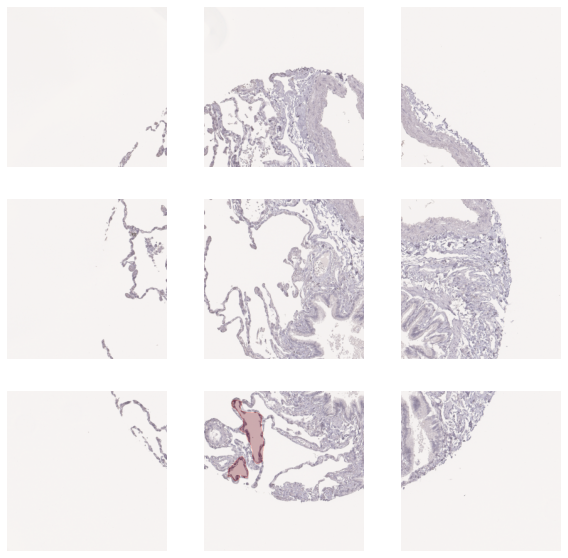

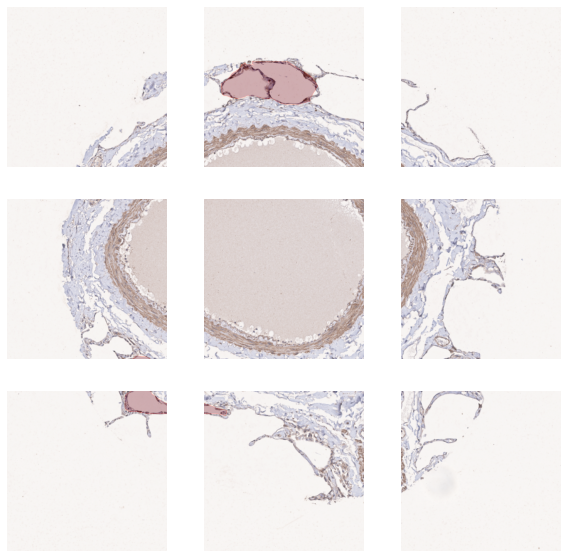

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9) :
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[i])
  plt.imshow(y_train[i], cmap = 'Reds', alpha = 0.3)
  plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
for i in range(9,18) :
  plt.subplot(3,3,i-8)
  plt.imshow(x_train[i])
  plt.imshow(y_train[i], cmap = 'Reds', alpha = 0.3)
  plt.axis('off')
plt.show()

# Model(deeplabv3+)

In [ ]:
# Entry Flow

def entry_flow(x) : 
  y = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.Conv2D(filters = 64, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)

  r = layers.Conv2D(128, kernel_size = (1,1), strides = (2,2))(y)

  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3), strides = (2,2))(y)

  # residual과 resolution이 약간 달라서 reshape
  y = layers.Resizing(r.shape[1], r.shape[2])(y)
  z1 = layers.Add()([y,r])
  z1 = layers.BatchNormalization()(z1)
  z1 = layers.Activation('relu')(z1)


  r = layers.Conv2D(256, kernel_size = (1,1), strides = (2,2))(z1)

  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(z1)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = layers.Add()([y,r])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  r = layers.Conv2D(728, kernel_size = (1,1), strides = (2,2))(z)

  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = layers.Add()([y,r])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  return z,z1

In [ ]:
# Middle flow

def middle_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y) 
  y = layers.Resizing(x.shape[1], x.shape[2])(y)

  z = layers.Add()([y,x])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)
  return z

In [ ]:
# Exit flow

def exit_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3), strides = (2,2))(y)
  x = layers.SeparableConv2D(filters = 1024, kernel_size = (1,1), strides = (1,1))(x)
  y = layers.Resizing(x.shape[1], x.shape[2])(y)


  z = layers.Add()([y,x])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 2048, kernel_size = (3,3))(y)
  return y  

In [ ]:
def decoder(low_img, aspp_img) :
  from tensorflow._api.v2.image import ResizeMethod
  low_level_img = layers.Conv2D(2048, kernel_size = (1,1))(low_img)   # ASPP 통과한 이미지와 채널 수 맞춤

  size = (low_img.shape[1],low_img.shape[2]) # resize img
  ASPP_img = tf.image.resize(aspp_img, size = size, method = ResizeMethod.BILINEAR)    # low level 이미지와 ASPP 통과한 이미지 resolution 맞춤

  concat_img = tf.concat([low_level_img, ASPP_img], axis = -1)

  concat_img = layers.Conv2D(1, kernel_size = (3,3))(concat_img)
  img = tf.image.resize(concat_img, size = (255,255), method = ResizeMethod.BILINEAR)

  return img

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
# loss
def dice_loss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [ ]:
def deeplabv3(x) :
  z, low_level_feature = entry_flow(x)
  z = middle_flow(z)
  ASPP_feature = exit_flow(z)
  output =  decoder(low_level_feature, ASPP_feature)
  model = models.Model(x, output)
  model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_loss])
  return model

# Augumentation

In [ ]:
# augumentation
aug_layer= tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

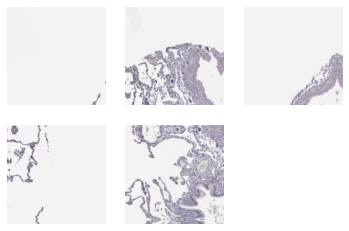

In [ ]:
for i in range(5) :
  aug_img = aug_layer(x_train[i])
  plt.subplot(2,3,i+1)
  plt.imshow(aug_img)
  plt.axis('off')

In [ ]:
input_shape = (255,255,3)
x = layers.Input(input_shape)
y = aug_layer(x)
model = deeplabv3(y)
model.summary()

# fit

In [ ]:
y_train[0].shape

(255, 255)

In [ ]:
from tensorflow.keras import callbacks

ckp = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Competition/HuBMAP/model_save/model_lung.h5', # 모델 저장 경로
                                save_best_only = True, # 가장 성능이 좋은 모델만 저장
                                monitor = 'val_dice_loss') 

early = callbacks.EarlyStopping(monitor = 'val_dice_loss',
                                patience = 5)

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size = 9, 
                    epochs = 20,
                    validation_split = 0.1,
                    shuffle = True)

Epoch 1/20
44/44 [==============================] - 14s 307ms/step - loss: 0.9163 - accuracy: 0.7640 - dice_loss: 0.9130 - val_loss: 0.9362 - val_accuracy: 0.8235 - val_dice_loss: 0.9338
Epoch 2/20
44/44 [==============================] - 14s 307ms/step - loss: 0.8850 - accuracy: 0.3126 - dice_loss: 0.8873 - val_loss: 0.9855 - val_accuracy: 0.9737 - val_dice_loss: 0.9852
Epoch 3/20
44/44 [==============================] - 13s 298ms/step - loss: 0.9731 - accuracy: 0.0611 - dice_loss: 0.9735 - val_loss: 0.9791 - val_accuracy: 0.0000e+00 - val_dice_loss: 0.9788
Epoch 4/20
44/44 [==============================] - 13s 291ms/step - loss: 0.9540 - accuracy: 0.0221 - dice_loss: 0.9549 - val_loss: 0.9710 - val_accuracy: 0.0022 - val_dice_loss: 0.9704
Epoch 5/20
44/44 [==============================] - 13s 290ms/step - loss: 0.9517 - accuracy: 0.0209 - dice_loss: 0.9526 - val_loss: 0.9703 - val_accuracy: 0.0154 - val_dice_loss: 0.9699
Epoch 6/20
44/44 [==============================] - 13s 292ms